# Segmentation Demo

## Demo Overview

In this demonstration we will train a UNet segmentation model to perform pixelwise classification of turtle images. The scales on the face of sea turtles are unique and can be used to identify an individual turtle. The UNet segmentation model was built to remove everything in an image with the exception of turtle faces. Pixels that correspond to a turtle's face are labeled as a 1, all other pixels are classified 0 which correspond to a background class.

## Imports Packages, Action Sets and Creates Connection Object

In [1]:
# Imports the necessary packages

import os 
import yaml
import swat
import pandas as pd
import dlpy
from dlpy import mzmodel
from dlpy.utils import *
from dlpy.applications import *
from glob import glob
from PIL import Image
from glob import glob
import seaborn as sns

/opt/conda/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
# Creates the connection object

conn = swat.CAS("server.demo.sas.com", 30570, 'student', 'Metadata0')

In [3]:
# Change timeout

mytime = 60*60*24
conn.session.timeout(time=mytime)

+ Elapsed: 0.000159s, user: 0.000147s, mem: 0.207mb

In [4]:
# Loads the necessary action sets

conn.loadactionset("dlModelzoo")
conn.loadactionset("image")
conn.loadactionset("sampling")

NOTE: Added action set 'dlModelzoo'.
NOTE: Added action set 'image'.
NOTE: Added action set 'sampling'.


[actionset]

 'sampling'

+ Elapsed: 0.00268s, user: 0.00213s, sys: 0.000521s, mem: 0.217mb

In [5]:
# Add CAS library 

conn.table.addCaslib(name="mycl", path="/workshop/winsas/VOSI", dataSource="PATH", subdirectories = True, activeOnAdd=False)

NOTE: Cloud Analytic Services added the caslib 'mycl'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient,TableRedistUpPolicy
0,mycl,PATH,,/workshop/winsas/VOSI/,,1.0,1.0,0.0,0.0,0.0,0.0,Not Specified


In [6]:
# Sets mycl as the session library

conn.setsessopt(caslib = "mycl")

NOTE: 'mycl' is now the active caslib.


+ Elapsed: 0.000487s, user: 0.000361s, sys: 0.00011s, mem: 0.277mb

## Segmentation Table Creation and Exploration

**NOTE:** Code to create segmentation table is commented out. Table is already created and will be loaded into memory instead.

In [7]:
# Creates DLPy image tables

images_tbl = dlpy.images.ImageTable.load_files(conn, path = "/workshop/winsas/VOSI/images", casout = dict(name = "images_tbl")) 
masks_tbl  = dlpy.images.ImageTable.load_files(conn, path = "/workshop/winsas/VOSI/processed" , casout = dict(name = "masks_tbl")) 

In [8]:
# Displays a summary for the images

images_tbl.image_summary

jpg                    100.0
minWidth               256.0
maxWidth               256.0
minHeight              256.0
maxHeight              256.0
meanWidth              256.0
meanHeight             256.0
mean1stChannel    132.217394
min1stChannel            0.0
max1stChannel          255.0
mean2ndChannel    125.502269
min2ndChannel            0.0
max2ndChannel          255.0
mean3rdChannel    124.329379
min3rdChannel            0.0
max3rdChannel          255.0
dtype: object

In [9]:
# Displays a summary for the masks

masks_tbl.image_summary

jpg                  100.0
minWidth             256.0
maxWidth             256.0
minHeight            256.0
maxHeight            256.0
meanWidth            256.0
meanHeight           256.0
mean1stChannel    0.294469
min1stChannel          0.0
max1stChannel          1.0
mean2ndChannel    0.294469
min2ndChannel          0.0
max2ndChannel          1.0
mean3rdChannel    0.294469
min3rdChannel          0.0
max3rdChannel          1.0
dtype: object

In [10]:
# # Creates a table that associates the raw images with their corresponding masks

# seg_table = dlpy.utils.create_segmentation_table(conn, path_to_images="/workshop/winsas/VOSI/images", path_to_ground_truth="/workshop/winsas/VOSI/processed", output_table_name="seg_tbl")

In [11]:
# Loads the segmentation table into memory

conn.table.loadtable(path = "seg_data.sashdat", caslib = "mycl", casout = dict(name = "seg_tbl", replace = True))

NOTE: Cloud Analytic Services made the file seg_data.sashdat available as table SEG_TBL in caslib mycl.


[caslib]

 'mycl'

[tableName]

 'SEG_TBL'

[casTable]

 CASTable('SEG_TBL', caslib='mycl')

+ Elapsed: 0.00148s, user: 0.00138s, mem: 0.717mb

In [12]:
# Displays a sample of the segmentation dataset

seg_tbl = conn.CASTable("seg_tbl")
seg_tbl.head()

,_filename_0,_image_,_label_,_id_,labels,image_path,label_path,ID,_PartInd_
0,GAL133_P5220861.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,images/GAL133_P5220861.png,processed/GAL133_P5220861.png,GAL133,0.0
1,GAL128_P5220712.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,33,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,images/GAL128_P5220712.png,processed/GAL128_P5220712.png,GAL128,1.0
2,GAL26_PB220991.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,63,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,images/GAL26_PB220991.png,processed/GAL26_PB220991.png,GAL26,1.0
3,GAL160_P6272319.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,94,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,images/GAL160_P6272319.png,processed/GAL160_P6272319.png,GAL160,1.0
4,GAL95_P5170205.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,images/GAL95_P5170205.png,processed/GAL95_P5170205.png,GAL95,0.0


## Exploring Data Partition

**NOTE:** The loaded table contains a partition indicator. Rows with a _PartInd_ value of 1 belong to the training partition and values of 0 belong to the validation partition. 

In [13]:
# Examines the dataset partition 

seg_tbl["_PartInd_"].value_counts(normalize = True)

1.0    0.8
0.0    0.2
dtype: float64

In [14]:
# Creates separate objects for training and validation partitions

train = seg_tbl.query("_PartInd_ = 1")
valid = seg_tbl.query("_PartInd_ = 0")

NOTE: The HISTOGRAM_EQUALIZATION function accepts only images whose depth is 8-bit unsigned character.
NOTE: The table SEG_TBL contains encoded images.
NOTE: 100 of 100 images were processed successfully and saved as encoded images to the Cloud Analytic Services table segmentationImageProcessed_gDsouO.


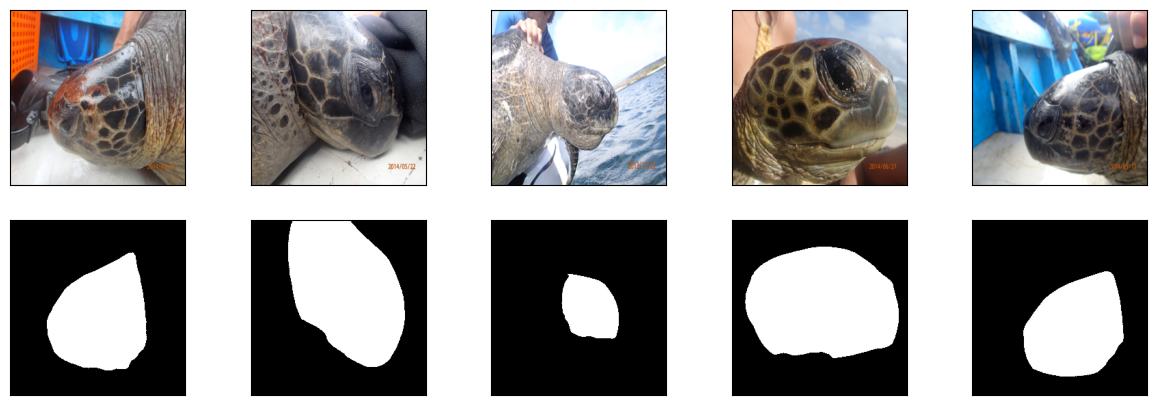

In [15]:
# Displays the images and their corresponding masks

display_segmentation_images(conn, "seg_tbl", segmentation_labels_table = "seg_tbl", n_images = 5, fig_size = (15,5))

## UNet Model Definition

In [16]:
# Creates a UNet model object using the DLPy pre-built models utility

model = UNet(conn, n_classes = 2, n_channels = 3, bn_after_convolutions = True, output_image_type = "PNG")

NOTE: Model compiled successfully.


In [17]:
# Displays the architecture of the model in tabular form

model.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,data,input,,,None,"(256, 256, 3)","(0, 0)",0
1,1,Conv2d_1,convo,"(3, 3)","(1, 1)",Identity,"(256, 256, 64)","(1728, 0)",113246208
2,2,BN_1,batchnorm,,,Relu,"(256, 256, 64)","(0, 128)",0
3,3,Conv2d_2,convo,"(3, 3)","(1, 1)",Identity,"(256, 256, 64)","(36864, 0)",2415919104
4,4,BN_2,batchnorm,,,Relu,"(256, 256, 64)","(0, 128)",0
5,5,Pooling_1,pool,"(2, 2)","(2, 2)",Max,"(128, 128, 64)","(0, 0)",0
6,6,Conv2d_3,convo,"(3, 3)","(1, 1)",Identity,"(128, 128, 128)","(73728, 0)",1207959552
7,7,BN_3,batchnorm,,,Relu,"(128, 128, 128)","(0, 256)",0
8,8,Conv2d_4,convo,"(3, 3)","(1, 1)",Identity,"(128, 128, 128)","(147456, 0)",2415919104
9,9,BN_4,batchnorm,,,Relu,"(128, 128, 128)","(0, 256)",0


In [18]:
# Loads the weights of the pre-trained model

model.load("/workshop/winsas/Innovate/dl_demos/seg_demo/UNet.sashdat")

NOTE: Model table is loaded successfully!
NOTE: Model is renamed to "deep_learning_model" according to the model name in the table.
NOTE: UNet_weights.sashdat is used as model weights.
NOTE: Model weights attached successfully!
NOTE: UNet_weights_attr.sashdat is used as weights attribute.
NOTE: Model attributes attached successfully!


In [19]:
# Dataspecs parameters to define the images and masks

dataspecs=[dict(type='image', layer='data', data=['_image_']),
           dict(type='image', layer='Segmentation_1', data=['labels'])]

## Optimization Settings

In [20]:
# Specifies the ADAM optimization settings

adam = dlpy.model.AdamSolver(beta1 = 0.9, beta2 = 0.999, gamma = 0.5, learning_rate = 0.0005, 
                             learning_rate_policy = "step", step_size = 30, 
                             clip_grad_max = 100, clip_grad_min = -100)

In [21]:
# Specifies the optimization information

opt = dlpy.model.Optimizer(algorithm = adam, mini_batch_size = 5, max_epochs = 100, reg_l2=0.0005, seed = 42)

## UNet Training

**NOTE:** Training this model takes a few minutes in the current environment. The results of the model fitting process are shown, however, the model was loaded into memory along with it's pertinent weights.

In [21]:
# # Trains the model on the small training dataset

# train_results = model.fit(data = train, valid_table = valid, data_specs = dataspecs, optimizer = opt, 
#                 save_best_weights = True, log_level = 2, seed = 42, train_from_scratch = True, gpu = 1)

NOTE: Training from scratch.
NOTE: Due to data distribution, miniBatchSize has been limited to 3.
NOTE: Using controller.sas-cas-server-default.edu.svc.cluster.local: 1 out of 1 available GPU devices.


In [22]:
# Displays the training results

train_results

,Descr,Value
0,Model Name,unet
1,Model Type,Convolutional Neural Network
2,Number of Layers,51
3,Number of Input Layers,1
4,Number of Output Layers,0
5,Number of Convolutional Layers,19
6,Number of Pooling Layers,4
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,18
9,Number of Concatenation Layers,4


In [23]:
# Stores the optimization iteration history

loss_df = train_results["OptIterHistory"]
loss_df.head()

,Epoch,LearningRate,Loss,FitError,L2Norm,ValidLoss,ValidError
0,1,0.0005,42200.153125,0.348269,3.425043,58970.043750,0.270473
1,2,0.0005,37698.731250,0.311675,3.429313,50454.878125,0.258054
2,3,0.0005,35405.509375,0.286388,3.435968,31362.221875,0.246899
3,4,0.0005,32449.968750,0.258651,3.443188,82768.793750,0.257304
4,5,0.0005,36889.121875,0.283009,3.449631,29451.950000,0.230502


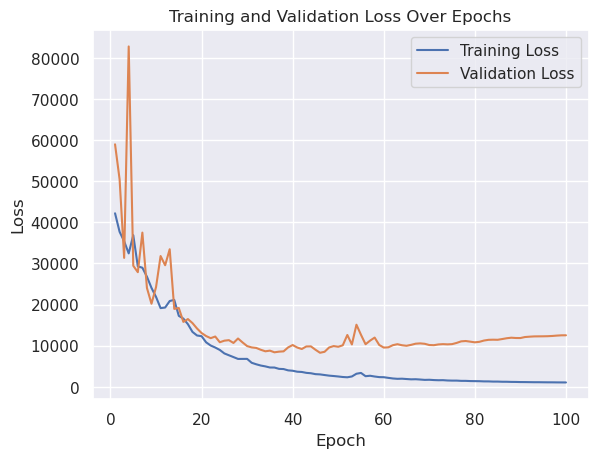

In [24]:
# Generates a plot of the training and validation loss

sns.set_theme()
unet_loss_plot = sns.lineplot(data = loss_df, x = "Epoch", y = "Loss", label = "Training Loss")
unet_loss_plot = sns.lineplot(data = loss_df, x = "Epoch", y = "ValidLoss", label = "Validation Loss")
unet_loss_plot.set_title("Training and Validation Loss Over Epochs")
plt.legend()
plt.legend()

Text(0.5, 1.0, 'Validation Error Over Epochs')

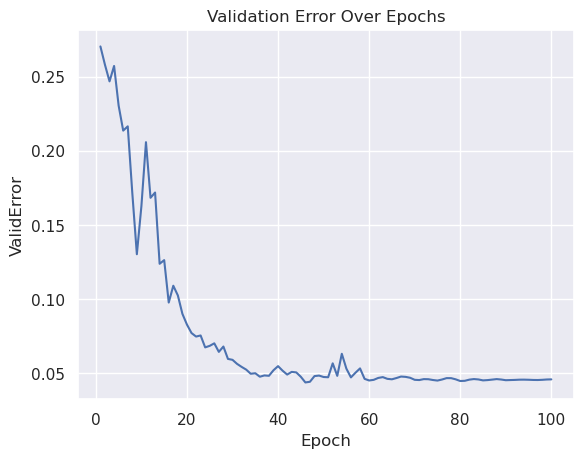

In [25]:
# Generates a plot of the validation error

sns.set_theme()
sns.lineplot(data = loss_df, x = "Epoch", y = "ValidError").set_title("Validation Error Over Epochs")

In [26]:
# # Saves the weights of the pre-trained model

# model.save_to_table("/workshop/winsas/Innovate/dl_demos/seg_demo/")

NOTE: Model table saved successfully.


## UNet Scoring

In [22]:
# Generates predictions using the U-Net model

model.predict(valid, gpu = 1)

NOTE: Due to data distribution, miniBatchSize has been limited to 2.
NOTE: Using controller.sas-cas-server-default.edu.svc.cluster.local: 1 out of 1 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            20
 1  Number of Observations Used            20
 2  Misclassification Error (%)      4.564819
 3           Pixel Accuracy (%)      95.43518
 4            Mean Accuracy (%)      93.51976
 5                 Mean IoU (%)      88.99598
 6   Frequency Weighted IoU (%)      91.31662
 7                   Loss Error      12542.36

[OutputCasTables]

   casLib              Name  Rows  Columns                                     casTable
 0   mycl  Valid_Res_YIPBc0    20       14  CASTable('Valid_Res_YIPBc0', caslib='mycl')

+ Elapsed: 20.2s, user: 6.39s, sys: 3.11s, mem: 1.31e+04mb

In [23]:
# Displays a sample of the predictions table

model.valid_res_tbl.fetch(to = 5)

NOTE: Varbinary column '_image_' may not be in a format that can be displayed consistently.
NOTE: Varbinary column 'labels' may not be in a format that can be displayed consistently.
NOTE: Varbinary column '_DL_PredImg_' may not be in a format that can be displayed consistently.


,_filename_0,_image_,_label_,_id_,labels,image_path,label_path,ID,_PartInd_,_DL_PredImg_,_DL_Pixel_Acc_,_DL_Mean_Acc_,_DL_Mean_IU_,_DL_Freq_IU_
0,GAL133_P5220861.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,images/GAL133_P5220861.png,processed/GAL133_P5220861.png,GAL133,0.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,92.422485,88.139168,82.282433,85.832649
1,GAL95_P5170205.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,images/GAL95_P5170205.png,processed/GAL95_P5170205.png,GAL95,0.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,93.591309,88.243034,83.860138,87.774147
2,GAL26_PB220990.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,32,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,images/GAL26_PB220990.png,processed/GAL26_PB220990.png,GAL26,0.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,95.132446,72.225121,66.255173,91.332260
3,GAL128_P5220720.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,images/GAL128_P5220720.png,processed/GAL128_P5220720.png,GAL128,0.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,95.108032,92.780846,88.579033,90.657051
4,GAL95_P5170211.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,98,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,images/GAL95_P5170211.png,processed/GAL95_P5170211.png,GAL95,0.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,98.977661,98.915955,96.922363,97.996567


In [24]:
# Stores the name of the results table

results_tbl = model.valid_res_tbl.name

NOTE: The HISTOGRAM_EQUALIZATION function accepts only images whose depth is 8-bit unsigned character.
NOTE: The table VALID_RES_YIPBC0 contains encoded images.
NOTE: 20 of 20 images were processed successfully and saved as encoded images to the Cloud Analytic Services table labelImageProcessed_cbHuUS.
NOTE: The HISTOGRAM_EQUALIZATION function accepts only images whose depth is 8-bit unsigned character.
NOTE: The table LABELIMAGEPROCESSED_CBHUUS contains encoded images.
NOTE: 20 of 20 images were processed successfully and saved as encoded images to the Cloud Analytic Services table allImageProcessed_UNEOKF.
4


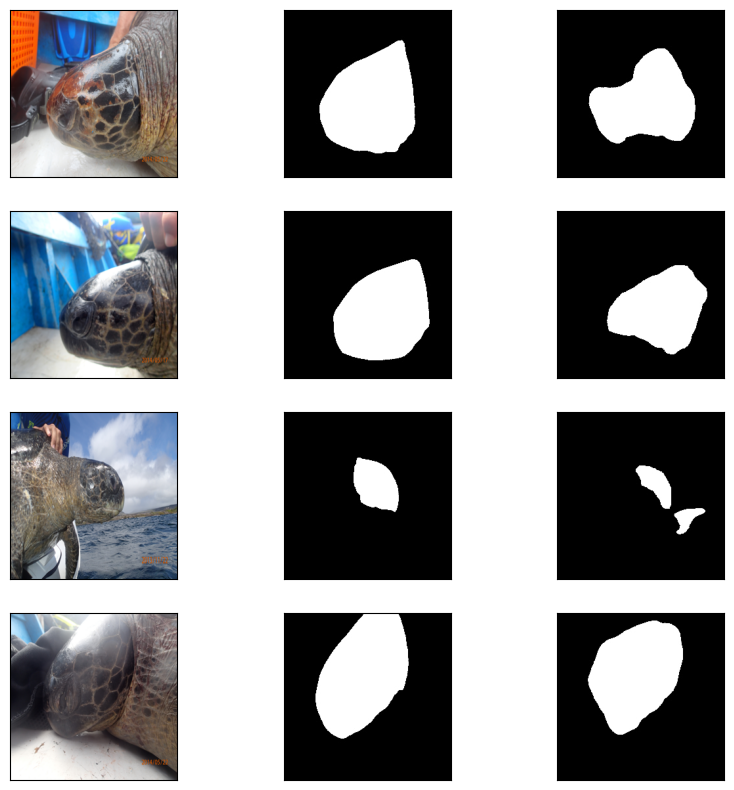

In [25]:
# Displays the segmentation results 

display_segmentation_results(conn, results_tbl, image_column='_image_', label_column = "labels", 
                             segmentation_labels_table = results_tbl, segmentation_prediction_table = results_tbl, prediction_column = "_DL_predImg_",
                             filename_column = "_filename_0", n_images = 4, fig_size = (10,10))

## Saves the Predicted Masks

In [26]:
# Specifies columns we want to keep

columns = ['labels', 'image_path', 'label_path', 'ID', '_PartInd_', '_DL_PredImg_']

In [27]:
# Saves the predicted masks

pred_table = dlpy.images.ImageTable.from_table(model.valid_res_tbl, columns = columns)

In [28]:
# Displays a sample of the final table

pred_table.head()

,_image_,_label_,_filename_0,_id_,labels,image_path,label_path,ID,_PartInd_,_DL_PredImg_
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,GAL133_P5220858.png,15,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,images/GAL133_P5220858.png,processed/GAL133_P5220858.png,GAL133,0.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,GAL95_P5170205.png,2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,images/GAL95_P5170205.png,processed/GAL95_P5170205.png,GAL95,0.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,GAL17_PB200665.png,99,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,images/GAL17_PB200665.png,processed/GAL17_PB200665.png,GAL17,0.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,GAL133_P5220861.png,1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,images/GAL133_P5220861.png,processed/GAL133_P5220861.png,GAL133,0.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,GAL11_PB150521.png,5,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,images/GAL11_PB150521.png,processed/GAL11_PB150521.png,GAL11,0.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


In [29]:
# List of columns to drop

to_drop = ['_image_', '_label_', 'labels', 'image_path', 'label_path', 'ID', '_PartInd_']
pred_table.drop(to_drop, axis = 1, inplace = True)

In [30]:
# Saves the predicted masks

pred_table.to_files("/workshop/winsas/Innovate/pred_masks/")

In [ ]:
# Ends the session

conn.session.endsession()